In [47]:
import numpy as np
import re
import string
import pandas as pd
from gensim.models import Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import utils
from nltk.corpus import stopwords
import nltk

In [48]:
def textClean(text):
    """
    Get rid of the non-letter and non-number characters
    """
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)


def cleanup(text):
    text = textClean(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text


def constructLabeledSentences(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences


def getEmbeddings(path,vector_dimension=300):
    """
    Generate Doc2Vec training and testing data
    """
    data = pd.read_csv(path)

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = cleanup(data.loc[i,'text'])

    x = constructLabeledSentences(data['text'])
    y = data['label'].values

    text_model = Doc2Vec(min_count=1, window=5, vector_size=vector_dimension, sample=1e-4, negative=5, workers=7, epochs=10,
                         seed=1)
    text_model.build_vocab(x)
    text_model.train(x, total_examples=text_model.corpus_count, epochs=text_model.iter)

    train_size = int(0.8 * len(x))
    test_size = len(x) - train_size

    text_train_arrays = np.zeros((train_size, vector_dimension))
    text_test_arrays = np.zeros((test_size, vector_dimension))
    train_labels = np.zeros(train_size)
    test_labels = np.zeros(test_size)

    for i in range(train_size):
        text_train_arrays[i] = text_model.docvecs['Text_' + str(i)]
        train_labels[i] = y[i]

    j = 0
    for i in range(train_size, train_size + test_size):
        text_test_arrays[j] = text_model.docvecs['Text_' + str(i)]
        test_labels[j] = y[i]
        j = j + 1

    return text_train_arrays, text_test_arrays, train_labels, test_labels


def clean_data():
    """
    Generate processed string
    """
    path = 'C:/Users/gauth/Desktop/courses/CS5604/project/dataset/train.csv'
    vector_dimension=300

    data = pd.read_csv(path)

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = cleanup(data.loc[i,'text'])

    data = data.sample(frac=1).reset_index(drop=True)

    x = data.loc[:,'text'].values
    y = data.loc[:,'label'].values

    train_size = int(0.8 * len(y))
    test_size = len(x) - train_size

    xtr = x[:train_size]
    xte = x[train_size:]
    ytr = y[:train_size]
    yte = y[train_size:]

    np.save('xtr_shuffled.npy',xtr)
    np.save('xte_shuffled.npy',xte)
    np.save('ytr_shuffled.npy',ytr)
    np.save('yte_shuffled.npy',yte)


In [49]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from collections import Counter
import os
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
from keras.models import Sequential
from keras.layers import Embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [50]:
top_words = 5000
epoch_num = 5
batch_size = 64

def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()

# Read the text data
if not os.path.isfile('./xtr_shuffled.npy') or \
    not os.path.isfile('./xte_shuffled.npy') or \
    not os.path.isfile('./ytr_shuffled.npy') or \
    not os.path.isfile('./yte_shuffled.npy'):
    clean_data()


xtr = np.load('./xtr_shuffled.npy', allow_pickle=True)
xte = np.load('./xte_shuffled.npy', allow_pickle=True)
y_train = np.load('./ytr_shuffled.npy', allow_pickle=True)
y_test = np.load('./yte_shuffled.npy', allow_pickle=True)

cnt = Counter()
x_train = []
for x in xtr:
    x_train.append(x.split())
    for word in x_train[-1]:
        cnt[word] += 1  

# Storing most common words
most_common = cnt.most_common(top_words + 1)
word_bank = {}
id_num = 1
for word, freq in most_common:
    word_bank[word] = id_num
    id_num += 1

# Encode the sentences
for news in x_train:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

y_train = list(y_train)
y_test = list(y_test)

# Delete the short news
i = 0
while i < len(x_train):
    if len(x_train[i]) > 10:
        i += 1
    else:
        del x_train[i]
        del y_train[i]

# Generating test data
x_test = []
for x in xte:
    x_test.append(x.split())

# Encode the sentences
for news in x_test:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

# Truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)


In [29]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing import sequence

# Define constants
top_words = 5000
embedding_vector_length = 32
max_review_length = 500

# Create the model
model = Sequential()

# Add the Embedding layer without input_length
model.add(Embedding(input_dim=top_words + 2, output_dim=embedding_vector_length))

# Add the LSTM layer
model.add(LSTM(units=100))

# Add the Dense output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, batch_size=batch_size)


Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 75s 291ms/step - accuracy: 0.7958 - loss: 0.4106 - val_accuracy: 0.9261 - val_loss: 0.2300
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 74s 295ms/step - accuracy: 0.9510 - loss: 0.1462 - val_accuracy: 0.8575 - val_loss: 0.3150
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 75s 297ms/step - accuracy: 0.9329 - loss: 0.1812 - val_accuracy: 0.9379 - val_loss: 0.1810
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 301ms/step - accuracy: 0.9710 - loss: 0.0921 - val_accuracy: 0.9458 - val_loss: 0.1693
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 74s 294ms/step - accuracy: 0.9851 - loss: 0.0534 - val_accuracy: 0.9357 - val_loss: 0.1893


In [30]:
# Display the model summary
print(model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 500, 32)             │         160,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 100)                 │          53,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 640,097 (2.44 MB)

 Trainable params: 213,365 (833.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 426,732 (1.63 MB)

None


In [31]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))


Accuracy= 93.57%


130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step


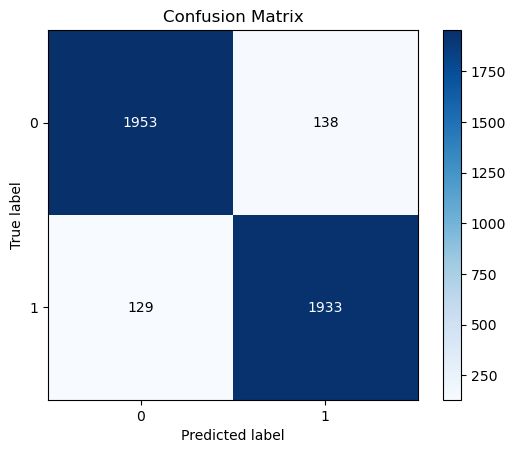

In [32]:
import scikitplot as skplt

# Define the plot_cmat function using scikitplot
def plot_cmat(y_true, y_pred):
    skplt.metrics.plot_confusion_matrix(y_true, y_pred)
    plt.show()
    
# Generate predictions
y_pred_proba = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Draw the confusion matrix
plot_cmat(y_test, y_pred)

In [39]:
model.save('LSTM-model.keras')

Accuracy = 83.84%


C:\Users\gauth\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


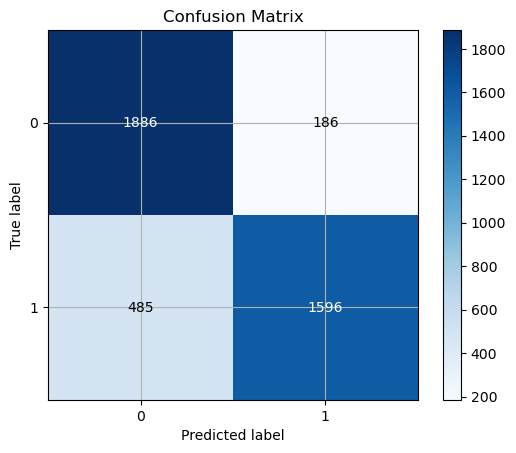

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
# Read the data
if not os.path.isfile('./xtr.npy') or \
    not os.path.isfile('./xte.npy') or \
    not os.path.isfile('./ytr.npy') or \
    not os.path.isfile('./yte.npy'):
    clean_data()

xtr = np.load('./xtr_shuffled.npy', allow_pickle=True)
xte = np.load('./xte_shuffled.npy', allow_pickle=True)
ytr = np.load('./ytr_shuffled.npy', allow_pickle=True)
yte = np.load('./yte_shuffled.npy', allow_pickle=True)

# Create a CountVectorizer instance
vectorizer = CountVectorizer()

# Fit the vectorizer on the text data and transform it into numerical features
xtr_numeric = vectorizer.fit_transform(xtr)

xtr_numeric_dense = xtr_numeric.toarray()

xte_numeric_sparse = vectorizer.transform(xte)
xte_numeric_dense = xte_numeric_sparse.toarray()
# Use the built-in Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(xtr_numeric_dense,ytr)
y_pred = gnb.predict(xte_numeric_dense)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 83.94%

# Draw the confusion matrix
plot_cmat(yte, y_pred)

In [85]:
import joblib
joblib.dump(gnb, 'gnb_model.pkl')

['gnb_model.pkl']

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical
import numpy as np

def baseline_model(input_dim):
    '''Neural network with 3 hidden layers'''
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu', kernel_initializer='normal'))
    model.add(Dense(2, activation="softmax", kernel_initializer='normal'))

    # gradient descent
    sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    # configure the learning process of the model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Preprocess data and convert to numerical features
x_train, x_test, y_train, y_test = train_test_split(xtr, ytr, test_size=0.2, random_state=42)

print(x_train.shape)

(13286,)


In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=300)

# Fit and transform the training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Check the shape of the transformed data
print("Shape of x_train_tfidf:", x_train_tfidf.shape)
print("Shape of x_test_tfidf:", x_test_tfidf.shape)

Shape of x_train_tfidf: (13286, 300)
Shape of x_test_tfidf: (3322, 300)


C:\Users\gauth\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 80)                  │          20,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 2)                   │             162 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 163,570 (638.95 KB)

 Trainable params: 163,570 (638.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4819 - loss: 0.6936
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5006 - loss: 0.6932
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5231 - loss: 0.6929
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5211 - loss: 0.6925
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5216 - loss: 0.6920
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5630 - loss: 0.6916
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6368 - loss: 0.6909
Epoch 8/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6401 - loss: 0.6902
Epoch 9/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6384 - loss: 0.6890
Epoch 10/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6763 - loss: 0.6878
Epoch 11/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6904 - loss: 0.6859
Epoch 12/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

C:\Users\gauth\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


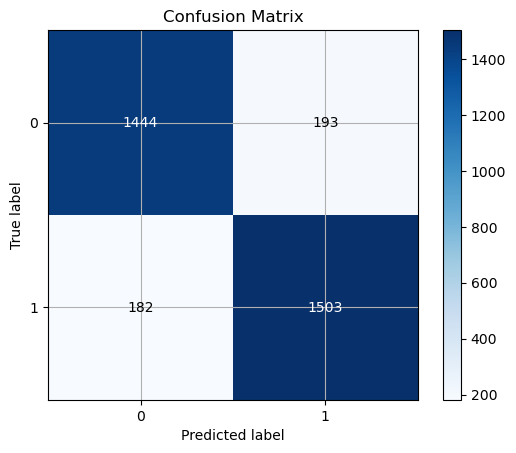

In [82]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def baseline_model(input_dim):
    '''Neural network with 3 hidden layers'''
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu', kernel_initializer='normal'))
    model.add(Dense(2, activation="softmax", kernel_initializer='normal'))

    # gradient descent
    sgd = SGD(learning_rate=0.01)

    # configure the learning process of the model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Train the model
model = baseline_model(x_train_tfidf.shape[1])
model.summary()
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = to_categorical((label_encoder.transform(y_train)))
label_encoder.fit(y_test)
encoded_y_test = to_categorical((label_encoder.transform(y_test)))
estimator = model.fit(x_train_tfidf, encoded_y_train, epochs=20, batch_size=64)
print("Model Trained!")

# Evaluate the model
score = model.evaluate(x_test_tfidf, encoded_y_test)
print("")
print("Accuracy = " + format(score[1]*100, '.2f') + "%")   # 88.69%

# Predict probabilities
probabs = model.predict(x_test_tfidf)

# Convert probabilities to class labels
y_pred = np.argmax(probabs, axis=1)

# Draw the confusion matrix
plot_cmat(y_test, y_pred)

In [86]:
model.save('SGD-model.keras')

In [106]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
import os.path
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

IN_DIM = 300
CLASS_NUM = 2
LEARN_RATE = 0.0001
TRAIN_STEP = 20000
tensorflow_tmp = "tmp_tensorflow"

def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte,ypred)
    plt.show()

def constructLabeledSentences(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(TaggedDocument(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(300, activation='relu', input_shape=(IN_DIM,)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(300, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(300, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(CLASS_NUM, activation='softmax')
    ])
    return model


# Get the training and testing data from getEmbeddings
if not os.path.isfile('./xtr.npy') or \
    not os.path.isfile('./xte.npy') or \
    not os.path.isfile('./ytr.npy') or \
    not os.path.isfile('./yte.npy'):
    clean_data()

train_data = np.load('./xtr_shuffled.npy', allow_pickle=True)
eval_data = np.load('./xte_shuffled.npy', allow_pickle=True)
train_labels = np.load('./ytr_shuffled.npy', allow_pickle=True)
eval_labels = np.load('./yte_shuffled.npy', allow_pickle=True)

print("Shape of train_data:", train_data.shape)
print("Shape of eval_data:", eval_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of eval_labels:", eval_labels.shape)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=300)

# Fit and transform the training data
train_data_tfidf = tfidf_vectorizer.fit_transform(train_data)

# Transform the test data
eval_data_tfidf = tfidf_vectorizer.transform(eval_data)

# Check the shape of the transformed data
print("Shape of x_train_tfidf:", train_data_tfidf.shape)
print("Shape of x_test_tfidf:", eval_data_tfidf.shape)



Shape of train_data: (16608,)
Shape of eval_data: (4153,)
Shape of train_labels: (16608,)
Shape of eval_labels: (4153,)
Shape of x_train_tfidf: (16608, 300)
Shape of x_test_tfidf: (4153, 300)


Epoch 1/20
333/333 - 5s - 15ms/step - accuracy: 0.7734 - loss: 0.5038 - val_accuracy: 0.8965 - val_loss: 0.2498
Epoch 2/20
333/333 - 2s - 7ms/step - accuracy: 0.8937 - loss: 0.2561 - val_accuracy: 0.9116 - val_loss: 0.2151
Epoch 3/20
333/333 - 2s - 7ms/step - accuracy: 0.9111 - loss: 0.2277 - val_accuracy: 0.9133 - val_loss: 0.2083
Epoch 4/20
333/333 - 2s - 7ms/step - accuracy: 0.9161 - loss: 0.2105 - val_accuracy: 0.9164 - val_loss: 0.2032
Epoch 5/20
333/333 - 2s - 7ms/step - accuracy: 0.9226 - loss: 0.1974 - val_accuracy: 0.9189 - val_loss: 0.2011
Epoch 6/20
333/333 - 2s - 7ms/step - accuracy: 0.9235 - loss: 0.1929 - val_accuracy: 0.9196 - val_loss: 0.1969
Epoch 7/20
333/333 - 2s - 7ms/step - accuracy: 0.9264 - loss: 0.1829 - val_accuracy: 0.9198 - val_loss: 0.1980
Epoch 8/20
333/333 - 2s - 7ms/step - accuracy: 0.9323 - loss: 0.1760 - val_accuracy: 0.9227 - val_loss: 0.1959
Epoch 9/20
333/333 - 2s - 7ms/step - accuracy: 0.9337 - loss: 0.1715 - val_accuracy: 0.9237 - val_loss: 0.1927


C:\Users\gauth\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


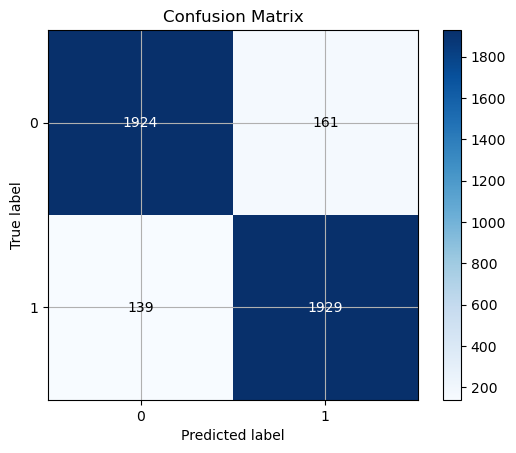

In [108]:
# Define the model
model = create_model()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_data_tfidf, train_labels, epochs=20, batch_size=50,
                    validation_data=(eval_data_tfidf, eval_labels), verbose=2)

# Evaluate the model
eval_loss, eval_acc = model.evaluate(eval_data_tfidf, eval_labels)
print('Evaluation accuracy:', eval_acc)

# Plot confusion matrix
y_pred = np.argmax(model.predict(eval_data_tfidf), axis=1)
plot_cmat(eval_labels, y_pred)



In [109]:
model.save('TF-model.keras')

Shape of x_train_tfidf: (16608, 300)
Shape of x_test_tfidf: (4153, 300)
Accuracy: 0.9407657115338309


C:\Users\gauth\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


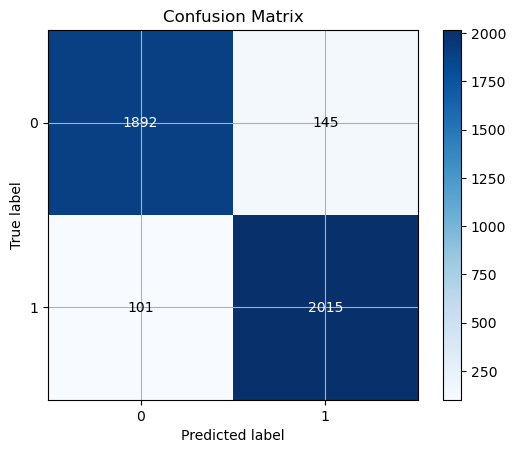

In [111]:
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
import os

# Load the training and evaluation data
if not os.path.isfile('./xtr.npy') or \
    not os.path.isfile('./xte.npy') or \
    not os.path.isfile('./ytr.npy') or \
    not os.path.isfile('./yte.npy'):
    clean_data()

x_train = np.load('./xtr_shuffled.npy', allow_pickle=True)
x_test = np.load('./xte_shuffled.npy', allow_pickle=True)
y_train = np.load('./ytr_shuffled.npy', allow_pickle=True)
y_test = np.load('./yte_shuffled.npy', allow_pickle=True)

# Convert text data into numerical features using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=300)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Check the shape of the transformed data
print("Shape of x_train_tfidf:", x_train_tfidf.shape)
print("Shape of x_test_tfidf:", x_test_tfidf.shape)

# Train the SVM model
clf = SVC()
clf.fit(x_train_tfidf, y_train)

# Predict on the evaluation data
y_pred = clf.predict(x_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
skplt.plot_confusion_matrix(y_test, y_pred)
plt.show()

In [113]:
import joblib
joblib.dump(clf, 'SVC_model.pkl')

['SVC_model.pkl']